这里，主要是关注如何调试、确定输入的数据，是期望的样子。
涉及到将输入的图片画出来，将对应的label显示出来。

主要参考：
https://damienpontifex.com/2017/12/02/inspecting-tfrecord-files-and-debugging-tensorflow-data-input/


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
['__add__', '__class__', '__contains__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getnewargs__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '_asdict', '_fields', '_make', '_replace', '_source', 'count', 'index', 'test', 'train', 'validation']
train data:  [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]] (55000, 784) 55000 (784,)
test data:  10000 (784,)
va

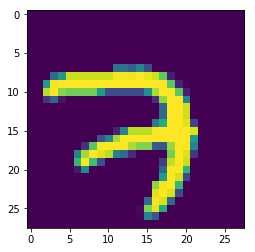

first label of first image is:  7
done.


784

In [7]:
import tensorflow as tf
import numpy as np

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

def input(dataset):
    return dataset.images, dataset.labels.astype(np.int32)

# Specify feature
feature_columns = [tf.feature_column.numeric_column("x", shape=[28, 28])]

# Define the training inputs
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": input(mnist.train)[0]},
    y=input(mnist.train)[1],
    num_epochs=None,
    batch_size=1,
    shuffle=True
)
print (dir(mnist))
print ('train data: ', mnist.train.images, mnist.train.images.shape, len(mnist.train.images), mnist.train.images[1000].shape)
print ('test data: ', len(mnist.test.images), mnist.test.images[1000].shape)
print ('validation data: ', len(mnist.validation.images), mnist.validation.images[1000].shape)

print ('train data of lables: ', len(mnist.train.labels), mnist.train.labels.shape, mnist.train.labels[1000])

# show image
import matplotlib.pyplot as plt
first_array=mnist.train.images[0]
print ('first data: ', first_array)
image_data = first_array.reshape((28, 28))
print ('image_data: ', image_data)


#Not sure you even have to do that if you just want to visualize it
#first_array=255*first_array
#first_array=first_array.astype("uint8")
plt.imshow(image_data)
#Actually displaying the plot if you are not in interactive mode
plt.show()
#Saving plot
plt.savefig("fig.png")
print ('first label of first image is: ', mnist.train.labels[0])
import matplotlib.pyplot as plt

print ('done.')
28*28

mnist有几个属性吧，3个是数据的属性：'test', 'train', 'validation'
其中,train data是55000条，每条为784个数字的数组，表示一个图片，28*28象素，每象素使用一个数字表示。28*28 = 784.
test有10000条数据，validation有5000条数据。长得都是一样的。
每个数据属性下面，还有images及labels属性；其中,labels属性；每个label为一个数字；


下面，我们将处理gnt的数据，目标为生成同样的数据。
数据来自网盘：https://pan.baidu.com/s/1o84jIrg
代码来自：https://github.com/burness/tensorflow-101/blob/master/chinese_hand_write_rec/src/chinese_rec.py


上面可以绘出7的图，以及显示这个图的label: 7


In [3]:
tf.app.flags.DEFINE_integer('charset_size', 3755, "Choose the first `charset_size` character to conduct our experiment.")
tf.app.flags.DEFINE_integer('image_size', 64, "Needs to provide same value as in training.")
tf.app.flags.DEFINE_boolean('gray', True, "whether to change the rbg to gray")
tf.app.flags.DEFINE_integer('max_steps', 12002, 'the max training steps ')
tf.app.flags.DEFINE_integer('eval_steps', 50, "the step num to eval")
tf.app.flags.DEFINE_integer('save_steps', 2000, "the steps to save")

tf.app.flags.DEFINE_string('checkpoint_dir', './checkpoint/', 'the checkpoint dir')
tf.app.flags.DEFINE_string('train_data_dir', '../data/train/', 'the train dataset dir')
tf.app.flags.DEFINE_string('test_data_dir', '../data/test/', 'the test dataset dir')
tf.app.flags.DEFINE_string('log_dir', './log', 'the logging dir')

tf.app.flags.DEFINE_boolean('restore', False, 'whether to restore from checkpoint')
tf.app.flags.DEFINE_boolean('epoch', 1, 'Number of epoches')
tf.app.flags.DEFINE_boolean('batch_size', 128, 'Validation batch size')
tf.app.flags.DEFINE_string('mode', 'train', 'Running mode. One of {"train", "valid", "test"}')
FLAGS = tf.app.flags.FLAGS

上面的代码不能执行2遍。否则flag会因为重复定义而出错？

In [15]:
import os
import random
from PIL import *

class DataIterator:
    def __init__(self, data_dir):
        # Set FLAGS.charset_size to a small value if available computation power is limited.
        truncate_path = data_dir + ('%05d' % FLAGS.charset_size)
        print(truncate_path)
        self.image_names = []
        for root, sub_folder, file_list in os.walk(data_dir):
            if root < truncate_path:
                self.image_names += [os.path.join(root, file_path) for file_path in file_list]
        random.shuffle(self.image_names)
        self.labels = [int(file_name[len(data_dir):].split(os.sep)[0]) for file_name in self.image_names]

    @property
    def size(self):
        return len(self.labels)

    def input_pipeline(self, batch_size, num_epochs=None, aug=False):
        images_tensor = tf.convert_to_tensor(self.image_names, dtype=tf.string)
        labels_tensor = tf.convert_to_tensor(self.labels, dtype=tf.int64)
        input_queue = tf.train.slice_input_producer([images_tensor, labels_tensor], num_epochs=num_epochs)

        labels = input_queue[1]
        images_content = tf.read_file(input_queue[0])
        images = tf.image.convert_image_dtype(tf.image.decode_png(images_content, channels=1), tf.float32)
        if aug:
            images = self.data_augmentation(images)
        new_size = tf.constant([FLAGS.image_size, FLAGS.image_size], dtype=tf.int32)
        images = tf.image.resize_images(images, new_size)
        image_batch, label_batch = tf.train.shuffle_batch([images, labels], batch_size=batch_size, capacity=50000,
                                                          min_after_dequeue=10000)
        return image_batch, label_batch
    
test_feeder = DataIterator(data_dir='../data/sandbox/')
print ('sandbox: ', test_feeder.size)

test_partial_data = test_feeder.input_pipeline(10)
print (test_partial_data[0][1], test_partial_data[1][1])



print ('====')

# sess = tf.InteractiveSession()

# print ( 'test index(folder name) is: ',test_partial_data[1][1].eval())  # [1, 2], dtype=tf.int32
# sess.close()

# sess = tf.InteractiveSession()
# Some tensor we want to print the value of
# a = tf.constant([1.0, 3.0])

# Add print operation
# a = tf.Print(a, [a], message="This is a: ")

a = test_partial_data
b = tf.to_float(a[0])
print ('b is: ', b)
out = tf.Print(b, [b, "anything I want"])

# sess = tf.Session()
# init_op = tf.global_variables_initializer()
# sess.run(init_op)
# print('input 1: ', sess.run(a))
# sess.close()
print ('here.')
print ('====')


../data/sandbox/03755
sandbox:  120
Tensor("strided_slice_23:0", shape=(64, 64, 1), dtype=float32) Tensor("strided_slice_24:0", shape=(), dtype=int64)
====
b is:  Tensor("shuffle_batch_11:0", shape=(10, 64, 64, 1), dtype=float32)
here.
====


test有test:  223991条数据。

取出10条test，其shape如下：<tf.Tensor 'shuffle_batch:0' shape=(10, 64, 64, 1) dtype=float32>,
 <tf.Tensor 'shuffle_batch:1' shape=(10,) dtype=int64>)
 
 原始数据中，有一个char_dict文件，内容部份如下：
 ```
 (dp0
V\u6000
p1
I1126
sV\u6302
p2
I1337
sV\u8000
p3
I2669
sV\u6d89
p4
I1906
sV\u8c08
p5
I3124
sV\u4f0a
p6
I121
```

In [36]:
print ('\u8c08', '\u4f0a')

谈 伊


其中，3124号目录中，是'谈'字。 121目录下，还真是'伊'字。


Show test data image:
https://stackoverflow.com/questions/33648322/tensorflow-image-reading-display

In [3]:
from IPython.display import Image
from IPython.display import display
display(Image(url='../data/test/03124/8243.png'))
display(Image(url='../data/train/01906/48580.png'))
display(Image(url='../data/test/01906/3018.png'))






上面的代码，会显示一个手写的“谈”字。以上代码来自：http://www.worthandlung.de/jupyter/display-gif-img-jupyter.html